In [2]:
import pandas as pd
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
from data.prepare_word2vec_ed import *
from data.prepare_data import *
from manual_labeling.labeled_data import SLOVA_PO_B, KONCOVKY_PRID_JMEN
from projections.base_projection import Projection

model = Word2Vec.load('utils/word2vec.model')

ps_data = get_ps_data()

slovab = {'name':'vyjmenovane_slova_b', 'data': get_vyjmenovana_slova_po_b(ps_data), 'labels': SLOVA_PO_B}
koncprid = {'name':'koncovky_prid_jmena', 'data': get_data_by_knowledge_component(ps_data, 36), 'labels': KONCOVKY_PRID_JMEN}
datasets = [slovab, koncprid]

#### Change the dataset below for another concept

In [3]:
dataset = datasets[0]

In [4]:
colors = ['blue', 'green', 'red', 'darkcyan', 'magenta', 'orange', 'darkgray', 'purple']

# t-SNE vs. PCA

In [183]:
data = dataset['data'].copy()
data.sort_values(['question_id'], inplace=True)
data.drop_duplicates(['question'], inplace=True)
data['solution'] = get_solutions(data, method='fillin')
data['full_solution'] = get_solutions(data, method='full')
label_data(data, dataset['labels'])

In [184]:
editdistance = create_edit_similarity_matrix(data['question_id'], data['solution'], levenshtein_similarity)
editdistance = editdistance.astype(float)

In [185]:
data.question_id.tolist() == editdistance.index.tolist()

True

### Koncovky pridavnych jmen

In [194]:
model = TSNE(perplexity=5, learning_rate=100, n_iter=100000)
result = model.fit_transform(editdistance)
x_positions = result[:, 0]
y_positions = result[:, 1]

In [195]:
model = PCA(n_components=2)
result = model.fit_transform(editdistance)
x_positions2 = result[:, 0]
y_positions2 = result[:, 1]

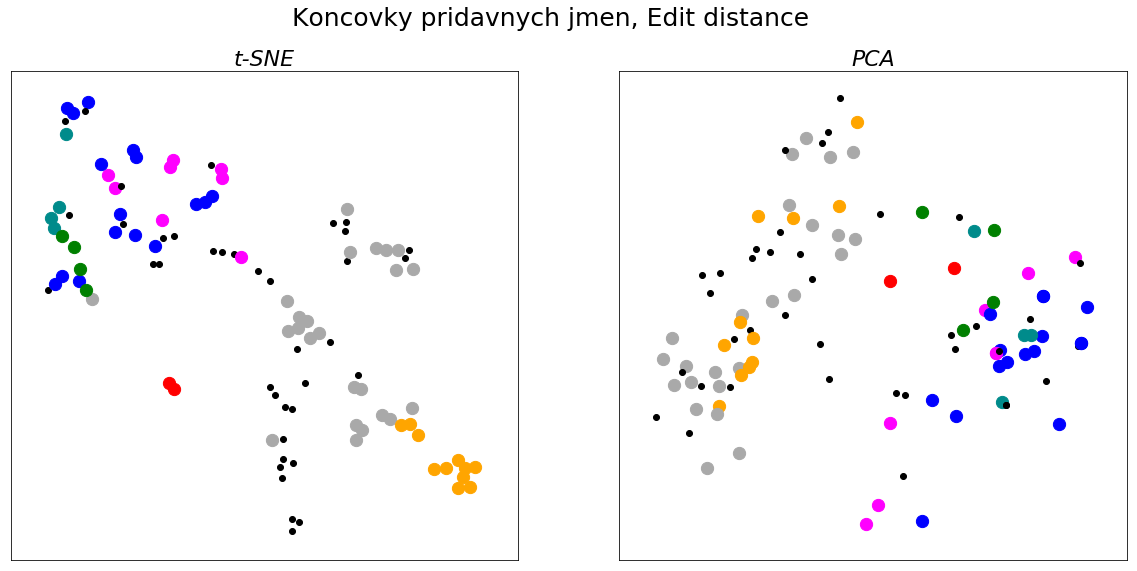

In [197]:
figure, (ax1, ax2) = plt.subplots(1,2)
data.reset_index(drop=True, inplace=True)
for i, row in data.iterrows():
    if row['manual_label'] != 0:
        ax1.scatter(x_positions[i], y_positions[i], c=colors[row['manual_label'] - 1], s=150)
    else:
        ax1.scatter(x_positions[i], y_positions[i], c='black')
ax1.set_title('t-SNE', fontsize=22, fontstyle='italic')
ax1.set_xticks([])
ax1.set_yticks([])
for i, row in data.iterrows():
    if row['manual_label'] != 0:
        ax2.scatter(x_positions2[i], y_positions2[i], c=colors[row['manual_label'] - 1], s=150)
    else:
        ax2.scatter(x_positions2[i], y_positions2[i], c='black')
ax2.set_title('PCA', fontsize=22, fontstyle='italic')
ax2.set_xticks([])
ax2.set_yticks([])
plt.suptitle('Koncovky pridavnych jmen, Edit distance', fontsize=25)
plt.gcf().set_size_inches(20, 9)
plt.show()

# Subplots of perplexity impact

In [2]:
name = 'word2vec'
model = Word2Vec.load('utils/word2vec.model')
X, data = get_word2vec_items(model, dataset['data'])
label_data(data, dataset['labels'])
data.sort_values(['question_id'], inplace=True)
data.drop_duplicates(['question'], inplace=True)

In [3]:
model = Word2Vec.load('utils/word2vec.model')
word2vec = create_word2vec_similarity_matrix(model, data['question_id'], data['solution'])

In [4]:
len(data.question.unique())

93

In [5]:
data.question_id.unique().tolist() == word2vec.index.tolist()

True

In [178]:
def change_subplot(subplot):
    x, y = subplot
    if y == 2:
        x += 1
        y = 0
    else:
        y +=1
    subplot = (x, y)
    return subplot

In [179]:
models = []
for perplexity in [2,5,10,20,50,100]:
    model = TSNE(perplexity=perplexity, learning_rate=50, n_iter=100000)
    result = model.fit_transform(word2vec)
    x_positions = result[:, 0]
    y_positions = result[:, 1]
    model = {'title': 'Perplexity ' + str(perplexity), 'x_positions': x_positions, 'y_positions': y_positions}
    models.append(model)

In [180]:
data.reset_index(drop=True, inplace=True)

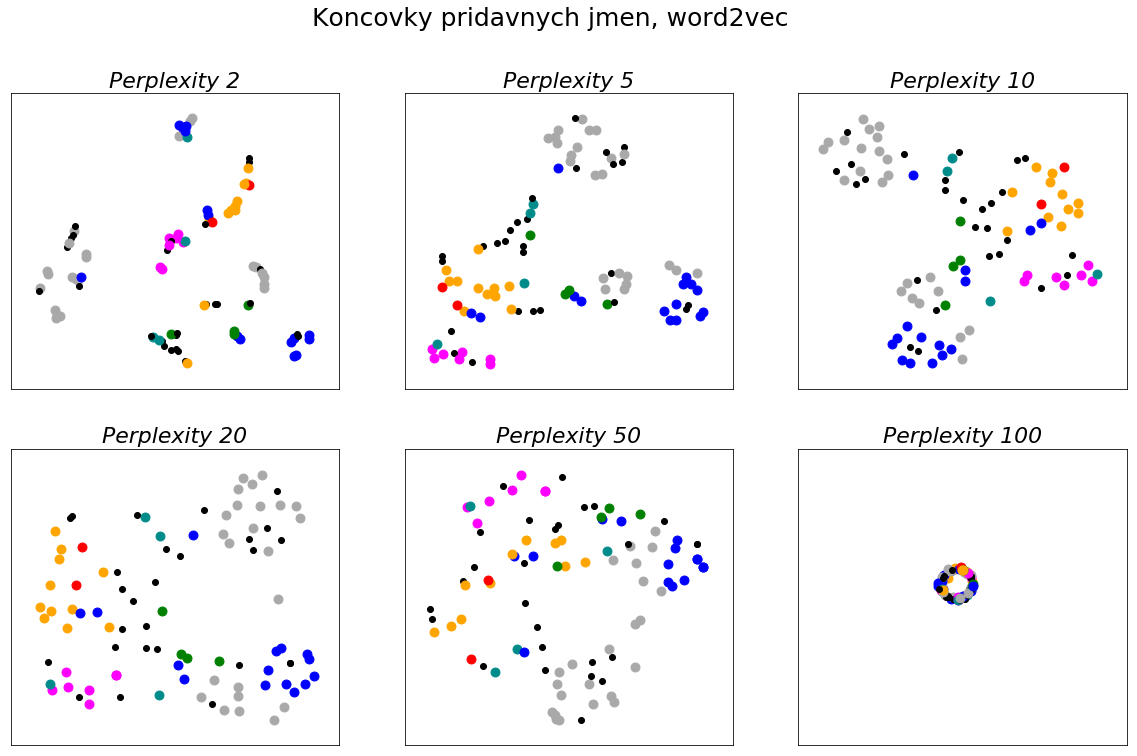

In [182]:
# perplexity
# first row - 2, 5, 10
# second row - 20, 50, 100
figure, axes = plt.subplots(2,3)
subplot = (0, 0)

for model in models:
    for i, row in data.iterrows():
        if row['manual_label'] != 0:
            axes[subplot].scatter(model['x_positions'][i], model['y_positions'][i], c=colors[row['manual_label'] - 1], s=80)
        else:
            axes[subplot].scatter(model['x_positions'][i], model['y_positions'][i], c='black')
    axes[subplot].set_title('%s' % (model['title']), fontsize=22, fontstyle='italic')
    axes[subplot].set_xticks([])
    axes[subplot].set_yticks([])
    subplot = change_subplot(subplot)        
plt.suptitle('Koncovky pridavnych jmen, word2vec', fontsize=25)
plt.gcf().set_size_inches(20, 12)
plt.show()

# Pearson

In [55]:
name = 'pearson'
data = dataset['data'].copy()
correctness_matrix = reshape_to_correctness_matrix(data)
pearson = correctness_matrix_to_similarity_matrix('pearson', correctness_matrix, True)

In [56]:
data.drop_duplicates(['question_id'], keep='first', inplace=True)
data = data[data['question_id'].isin(pearson.index)]
data.sort_values(['question_id'], inplace=True)
data['full_solution'] = get_solutions(data, method='full')
label_data(data, dataset['labels'])

In [57]:
data.question_id.tolist() == pearson.index.tolist()

True

In [64]:
model = TSNE(perplexity=8, learning_rate=50, n_iter=200000)
result = model.fit_transform(pearson)
projection = Projection(result[:, 0], result[:, 1], data.copy(), model=model)

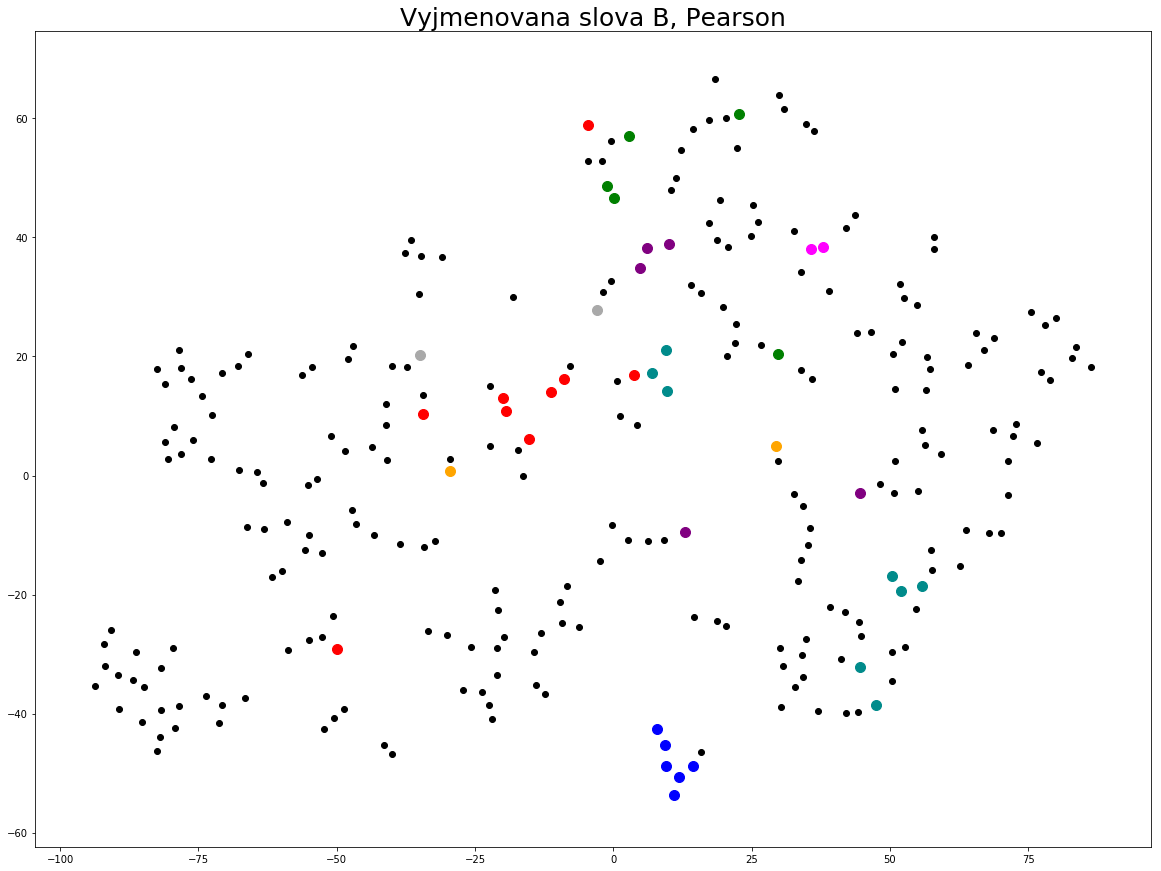

In [66]:
projection.matplotlib_plot_with_manual_labels(figsize=(20,15), annotate=False, markersize=100, title='Vyjmenovana slova B, Pearson', export=True, save_path='visualizations/tsne-vyjmenovanaslovaB-pearson-perplexity8.png')

In [67]:
projection.plotly_with_manual_labels(save_path='visualizations/plotly-vyjmenovanaslovaB-pearson-perplexity8.html', title='Vyjmenovana slova B, Pearson')

# Word2vec

In [11]:
name = 'word2vec'
model = Word2Vec.load('utils/word2vec.model')
X, data = get_word2vec_items(model, dataset['data'])
label_data(data, dataset['labels'])
data.sort_values(['question_id'], inplace=True)
data.drop_duplicates(['question'], inplace=True)

In [12]:
model = Word2Vec.load('utils/word2vec.model')
word2vec = create_word2vec_similarity_matrix(model, data['question_id'], data['solution'])

In [13]:
data.question_id.unique().tolist() == word2vec.index.tolist()

True

In [45]:
model = TSNE(perplexity=8, learning_rate=50, n_iter=100000)
result = model.fit_transform(word2vec)
projection = Projection(result[:, 0], result[:, 1], data.copy(), model=model)

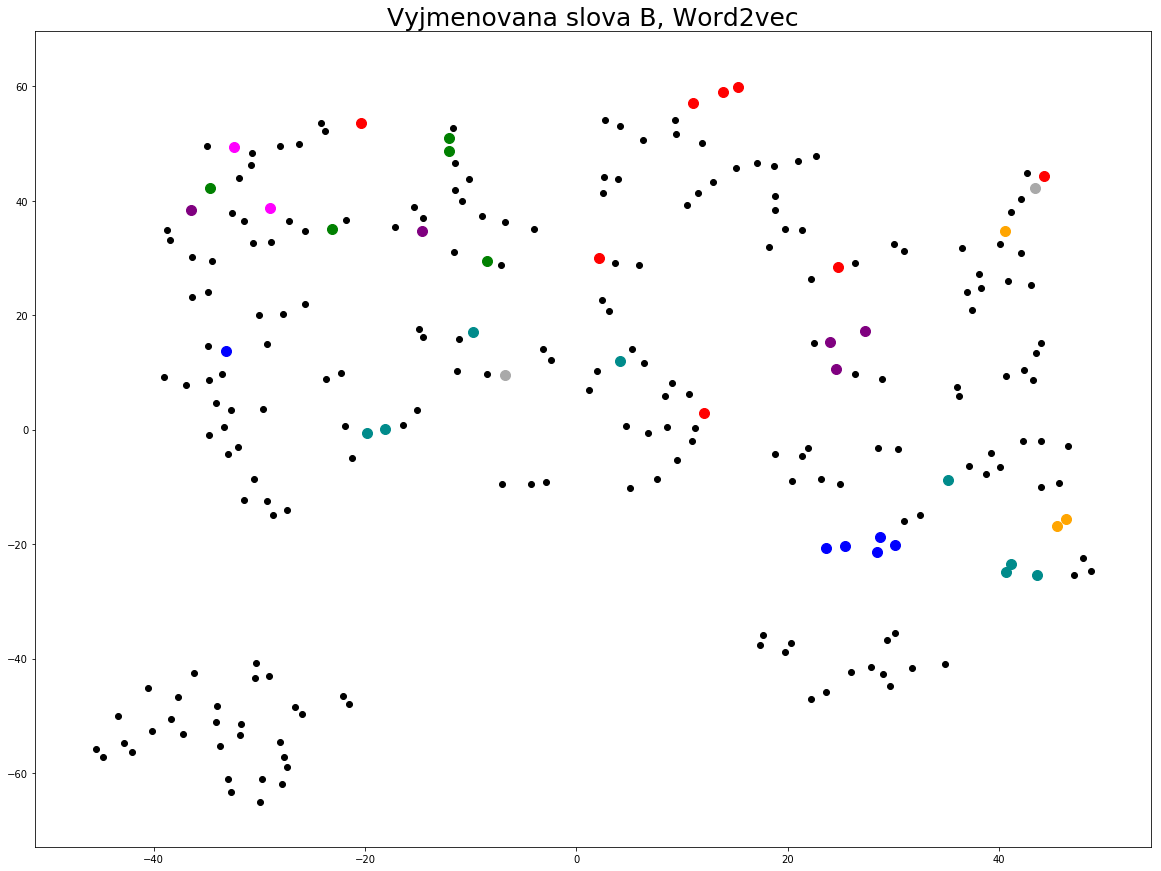

In [46]:
projection.matplotlib_plot_with_manual_labels(figsize=(20,15), annotate=False, markersize=100, title='Vyjmenovana slova B, Word2vec', export=True, save_path='visualizations/tsne-vyjmenovanaslovaB-word2vec-perplexity8.png')

In [47]:
projection.plotly_with_manual_labels(save_path='visualizations/plotly-vyjmenovanaslovaB-word2vec-perplexity8.html', title='Vyjmenovana slova B, Word2vec')

# Edit distance

In [48]:
data = dataset['data'].copy()
data.sort_values(['question_id'], inplace=True)
data.drop_duplicates(['question'], inplace=True)
data['solution'] = get_solutions(data, method='fillin')
data['full_solution'] = get_solutions(data, method='full')

In [49]:
editdistance = create_edit_similarity_matrix(data['question_id'], data['solution'], levenshtein_similarity)
editdistance = editdistance.astype(float)

In [50]:
data.question_id.tolist() == editdistance.index.tolist()

True

In [51]:
label_data(data, dataset['labels'])

In [52]:
model = TSNE(perplexity=12, learning_rate=100, n_iter=100000)
result = model.fit_transform(editdistance)
projection = Projection(result[:, 0], result[:, 1], data.copy(), model=model)

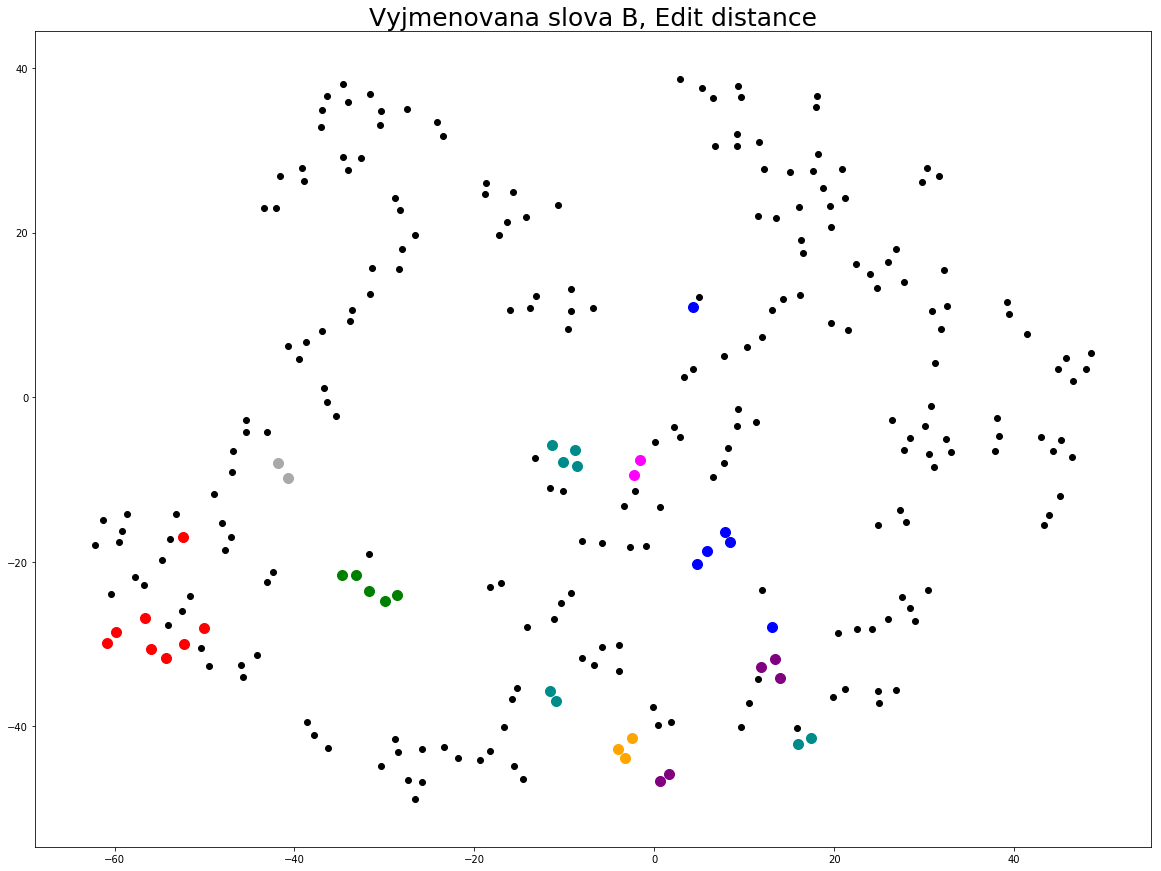

In [53]:
projection.matplotlib_plot_with_manual_labels(figsize=(20,15), annotate=False, markersize=100, title='Vyjmenovana slova B, Edit distance', export=True, save_path='visualizations/tsne-vyjmenovanaslovaB-editdistance-perplexity12.png')

In [54]:
projection.plotly_with_manual_labels(save_path='visualizations/plotly-vyjmenovanaslovaB-editdistance-perplexity12.html', title='Vyjmenovana slova B, Edit distance')

## If you determined the parameters for t-SNE, you can run t-SNE many times and choose the model with lowest kullback-leibler divergence. **model.kl\_divergence\_**
## For the visualizations in this notebook we used Euclidean distance on the similarity matrix within t-SNE algorithm.